In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import os
from Bio import SeqIO, Entrez
from urllib.error import HTTPError
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
def load_seq_from_FASTA(filename, as_type="list"):
    fasta_records = SeqIO.parse(open(filename),'fasta')
    if as_type=="dict":
        sequences = {}
        for fasta_record in fasta_records:
            sequences[fasta_record.id] = str(fasta_record.seq)
        return sequences
    elif as_type=="list":
        sequences = []
        for fasta_record in fasta_records:
            sequences.append(str(fasta_record.seq))
        return sequences
    else:
        raise ValueError(f"Desired type {as_type} not supported.")


Download the RNA-RNA interactions file from http://www.rnainter.org/download/

In [8]:
fn = os.path.join('..', 'data', 'sRNA', 'RNAInter', 'Download_data_RR.csv')
data = pd.read_csv(fn)
try:
    data = data.drop(columns=['Unnamed: 0'])
    data = data.drop(columns=['level_0'])
except:
    pass

In [9]:
data

index  RNAInterID Interactor1.Symbol Category1  \
0    1029724  RR05384747               acnA      mRNA   
1    1029725  RR05384845               acrZ      mRNA   
2    1029732  RR05387056               arcZ      sRNA   
3    1029733  RR05387057               arcZ      sRNA   
4    1029734  RR05387126               argR      mRNA   
..       ...         ...                ...       ...   
349  8031771  RR05460721               ryhB      sRNA   
350  8031772  RR05460722               sdsR      sRNA   
351  8031773  RR05460723               sgrS      sRNA   
352  8031774  RR05460724               sgrS      sRNA   
353  8051381  RR05460725               symE      mRNA   

                                      Species1 Interactor2.Symbol Category2  \
0    Escherichia coli str. K-12 substr. MG1655               ryhB      sRNA   
1    Escherichia coli str. K-12 substr. MG1655               omrB      sRNA   
2    Escherichia coli str. K-12 substr. MG1655               flhD      mRNA   
3    Escherichia coli str. K-12 substr. MG1655               rpoS      mRNA   
4    Escherichia coli str. K-12 substr. MG1655               dsrA      sRNA   
..                                         ...                ...       ...   
349  Escherichia coli str. K-12 substr. MG1655               ynfF      mRNA   
350  Escherichia coli str. K-12 substr. MG1655               tolC      mRNA   
351  Escherichia coli str. K-12 substr. MG1655               sodB      mRNA   
352  Escherichia coli str. K-12 substr. MG1655               yigL      mRNA   
353  Escherichia coli str. K-12 substr. MG1655               symR      sRNA   

                                      Species2       Raw_ID1       Raw_ID2  \
0    Escherichia coli str. K-12 substr. MG1655   NCBI:946724  NCBI:2847761   
1    Escherichia coli str. K-12 substr. MG1655   NCBI:945365  NCBI:2847747   
2    Escherichia coli str. K-12 substr. MG1655  NCBI:2847690   NCBI:945442   
3    Escherichia coli str. K-12 substr. MG1655  NCBI:2847690   NCBI:947210   
4    Escherichia coli str. K-12 substr. MG1655   NCBI:947861   NCBI:946470   
..                                         ...           ...           ...   
349  Escherichia coli str. K-12 substr. MG1655  NCBI:2847761   NCBI:945268   
350  Escherichia coli str. K-12 substr. MG1655  NCBI:2847772   NCBI:947521   
351  Escherichia coli str. K-12 substr. MG1655  NCBI:4056038   NCBI:944953   
352  Escherichia coli str. K-12 substr. MG1655  NCBI:4056038  NCBI:2847768   
353  Escherichia coli str. K-12 substr. MG1655   NCBI:949088  NCBI:5061533   

      score                                             strong        weak  \
0    0.2292                      Northern blot//Reporter assay         NaN   
1    0.1778                                      Northern blot  Microarray   
2    0.2314                      Northern blot//Reporter assay         NaN   
3    0.1996  Northern blot//RACE//RT-PCR//Beta-galactosidas...         NaN   
4    0.2139                             Primer extension assay         NaN   
..      ...                                                ...         ...   
349  0.1778                                      Northern blot  Microarray   
350  0.3292                        Northern blot//Western blot         NaN   
351  0.1983                                      Northern blot         NaN   
352  0.3273                      Northern blot//Reporter assay         NaN   
353  0.3330               RT-PCR//Reporter assay//Western blot         NaN   

     predict                                          Sequence1  \
0        NaN  ATTCGGAACGAGGCCTGAAGCAGTGTCGCCGTCCCTCTGCCTTGCA...   
1        NaN  ACTTACTACTGTCTTCGGGGGGTCCGAGGTTTCTGGGGGGTCGTAC...   
2        NaN  CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...   
3        NaN  CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...   
4        NaN  GACAATGGCGATAGTATGGCGGTTGTTTCTTTCCCATCTCTACTCA...   
..       ...                                                ...   
349      NaN  TTTGAGAGCGTCTCTG

# Minor pre-processing

## Filter species to only include E. coli

In [10]:
filt = ((data['Species1'] == 'Escherichia coli') | (data['Species1'] == 'Escherichia coli str. K-12 substr. MG1655')
        ) & ((data['Category1'] == 'sRNA') | (data['Category2'] == 'sRNA'))
# data[filt].reset_index().to_csv(fn)

In [11]:
data = data[filt].reset_index()

### Check for duplicates (mirrored interaction 1 and 2)

In [12]:
print('Number of duplicate entries:')
sum([len(data[(data['Interactor2.Symbol'] == i1) & (data['Interactor1.Symbol'] == i2)]) for i1, i2 in zip(data['Interactor1.Symbol'], data['Interactor2.Symbol'])])

Number of duplicate entries:


0

In [13]:
print('Number of unique raw IDs')
len(list(data['Raw_ID1'].unique()) + list(data['Raw_ID2'].unique()))

Number of unique raw IDs


308

<Axes: xlabel='score', ylabel='Count'>

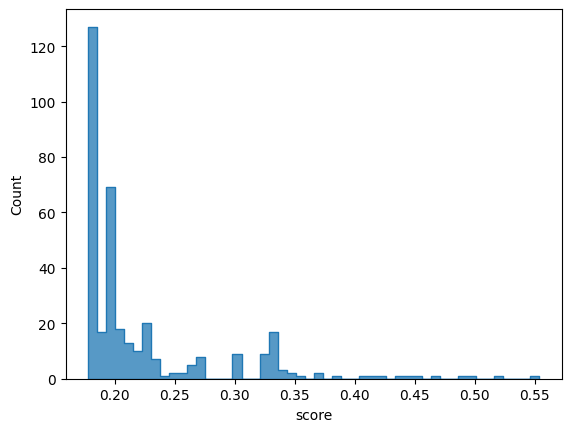

In [14]:
sns.histplot(data[filt], x='score', element='step', bins=50)

# Get sequences

In [15]:
Entrez.email = "olivia.gallup@gmail.com"  # Add your email address
Entrez.api_key = "8167226cf01abaa985a1c23d9b5283d22208"  # Add your NCBI API key


def get_seq_from_genome(gene_id):
    try:
        handle = Entrez.efetch(db="gene", id=gene_id, rettype="fasta", retmode="xml")
        record = Entrez.read(handle)
        nuc_id = record[0]['Entrezgene_locus'][0]['Gene-commentary_accession'] + '.' + record[0]['Entrezgene_locus'][0]['Gene-commentary_version']

        dna_start = record[0]['Entrezgene_locus'][0]['Gene-commentary_seqs'][0]['Seq-loc_int']['Seq-interval']['Seq-interval_from']
        dna_end = record[0]['Entrezgene_locus'][0]['Gene-commentary_seqs'][0]['Seq-loc_int']['Seq-interval']['Seq-interval_to']

        search_handle = Entrez.efetch(db="nuccore", id=nuc_id, retmode="XML", rettype='fasta_cds_na', strand="complement", seq_start=int(dna_start), seq_stop=int(dna_end))
        # dna_sequence = SeqIO.read(search_handle, "fasta").seq
        r = search_handle.read()
        if r:
            dna_sequence = ''.join(r.split('>')[1].split('\n')[1:])
        else:
            dna_sequence = ''
        return dna_sequence
    except HTTPError:
        return ''


def get_seq_info(gene_id):
    try:
        handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="fasta", retmode="text")
        fast = handle.read()
        seq = ''.join(fast.split('\n')[1:])
        if not seq or ('N' in seq):
            seq = get_seq_from_genome(gene_id)
        return seq
    except HTTPError:
        seq = get_seq_from_genome(gene_id)
        return seq


In [17]:
# if ('Sequence1' not in data.columns) or ('Sequence2' not in data.columns):
# data['Sequence1'] = data['Raw_ID1'].str.replace('NCBI:', '').apply(str).apply(get_fasta)
d = {k: get_seq_info(k) for k in list(data['Raw_ID1'].str.replace('NCBI:', '').apply(str).unique()) + list(data['Raw_ID2'].str.replace('NCBI:', '').apply(str).unique())}

for i, l in enumerate(zip(data['Raw_ID1'].str.replace('NCBI:', '').apply(str), data['Raw_ID2'].str.replace('NCBI:', '').apply(str))):
    data[f'Sequence{i+1}'] = list(map(lambda x: d[x], l))
    # data[f'Gene_Start{i+1}'] = list(map(lambda x: d[x][1], l))
    # data[f'Gene_End{i+1}'] = list(map(lambda x: d[x][2], l))
# data['Sequence1'] = data['Raw_ID1'].str.replace('NCBI:', '').apply(str).apply(get_fasta)

print(sum((data['Sequence1'] != '') & (data['Sequence2'] != '')))
data.to_csv(fn)


In [ ]:
data[data['Sequence1'].isna()]

Empty DataFrame
Columns: [level_0, index, RNAInterID, Interactor1.Symbol, Category1, Species1, Interactor2.Symbol, Category2, Species2, Raw_ID1, Raw_ID2, score, strong, weak, predict, Sequence1, Sequence2]
Index: []